# Figure to illustrate statistical accuracy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
from numpy.linalg import LinAlgError

# utils for plotting
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as colors
from plotly.subplots import make_subplots

from helpers import get_ablation_scores, get_scores

In [3]:
ground_truth ='sinexp' # 'sum_gauss'
d = 1
logn_lo = 8
logn_hi = 14
n_trials = 100

output_dir = 'output_scale_large'
fig_dir = os.path.join(output_dir, f'd={d}', 'figures') # directory to save figures
score_dir = os.path.join(output_dir, f'd={d}', 'scores_cv') # directory with saved scores

In [4]:
# nadaraya watson
method = 'nw'
kernel = 'epanechnikov'
nw_ablation_scores, nw_ablation_names = get_ablation_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
nw_scores, nw_names = get_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
all_nw_scores = nw_scores + nw_ablation_scores
all_nw_names = nw_names + nw_ablation_names
print(all_nw_names)

['full', 'st', 'k^2(x1,x2) + k(x1,x2) * y1*y2', 'k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k(x1,x2) * (1+ y1*y2)']


In [5]:
# kernel ridge regression
method = 'krr'
kernel = 'gaussian'
krr_ablation_scores, krr_ablation_names = get_ablation_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
krr_scores, krr_names = get_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
all_krr_scores = krr_scores + krr_ablation_scores
all_krr_names = krr_names + krr_ablation_names
print(all_krr_names)

['full', 'st', 'k(x1,x2) * (1+ y1*y2)', 'k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k^2(x1,x2) + k(x1,x2) * y1*y2']


In [6]:
krr_ablation_names

['k(x1,x2) * (1+ y1*y2)',
 'k(x1,x2)',
 'k((x1,x2), (y1,y2))',
 'k^2(x1,x2) + k(x1,x2) * y1*y2']

## Plotly version

In [36]:
# fig = go.Figure()
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Nadaraya-Watson (Epanechnikov)', 'Kernel Ridge Regression (Gaussian)'),
                    shared_yaxes=True)

colors_list = colors.qualitative.Plotly * 4
colors_used = {}

In [37]:

scale = 'log2'
# !!! MAKE SURE TO SET THE RIGHT BASELINE LOSS !!! 
baseline_loss = 1 # = noise**2

def plot(all_scores, all_names, row=1, col=1):
    for result in all_scores:
        name = result['name']
        # color = colors_list[all_names.index(name)]
        if name in colors_used:
            color = colors_used[name]
        else:
            color = colors_list[len(colors_used)]
        # print(name, result['logn'], np.mean(result["scores"]))
        excess_risk = np.array(result["scores"]) - baseline_loss

        if scale == 'log2':
            y = np.log2(excess_risk)
            # hline = np.log2(np.abs(baseline_loss))

        elif scale == 'linear':
            y = excess_risk
            # hline = np.abs(baseline_loss)
        trace = go.Box(
            x=[result['logn']]*len(result["scores"]),
            y=y,
            name=name,
            # opacity=0.5,
            legendgroup=name,
            line_color=color,
            offsetgroup=name,
            showlegend=name not in colors_used,
            boxmean=True,
            notched=name not in ['full', 'st', 'rpcholesky'],
        )

        fig.add_trace(trace, row=row, col=col)
        # colors_used.add(color)
        colors_used[name] = color


In [38]:
plot(all_nw_scores, all_nw_names, row=1, col=1)
plot(all_krr_scores, all_krr_names, row=1, col=2)

/tmp/ipykernel_501538/1827076423.py:17: RuntimeWarning:

invalid value encountered in log2



In [39]:
colors_used

{'full': '#636EFA',
 'st': '#EF553B',
 'k^2(x1,x2) + k(x1,x2) * y1*y2': '#00CC96',
 'k(x1,x2)': '#AB63FA',
 'k((x1,x2), (y1,y2))': '#FFA15A',
 'k(x1,x2) * (1+ y1*y2)': '#19D3F3'}

In [40]:
fig.update_yaxes(title_text=f"{scale}(excess risk)", row=1, col=1)
fig.update_xaxes(title_text="log2(n)", type='linear')
fig.update_layout(
    width=1200,
    height=600,
    # title=f"Excess risk vs n (ground_truth={ground_truth})",
    boxmode='group',
    font=dict(
        # family="Courier New, monospace",
        size=18,
    ),
    # plot_bgcolor='rgba(0, 0, 200, 0.5)',  # Light gray background with 50% opacity
)

In [41]:
# save fig to file
os.makedirs(fig_dir, exist_ok=True)
fig_file = os.path.join(
    fig_dir,
    f"all-gt={ground_truth}-logn={logn_lo}_{logn_hi}-t{n_trials}-excess.png"
)
fig.write_image(fig_file)

## Matplotlib version

Note: seems like you cannot customize the box plot fill style in plotly

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

/tmp/ipykernel_460488/481884404.py:14: RuntimeWarning:

invalid value encountered in log2

/tmp/ipykernel_460488/481884404.py:14: RuntimeWarning:

invalid value encountered in log2



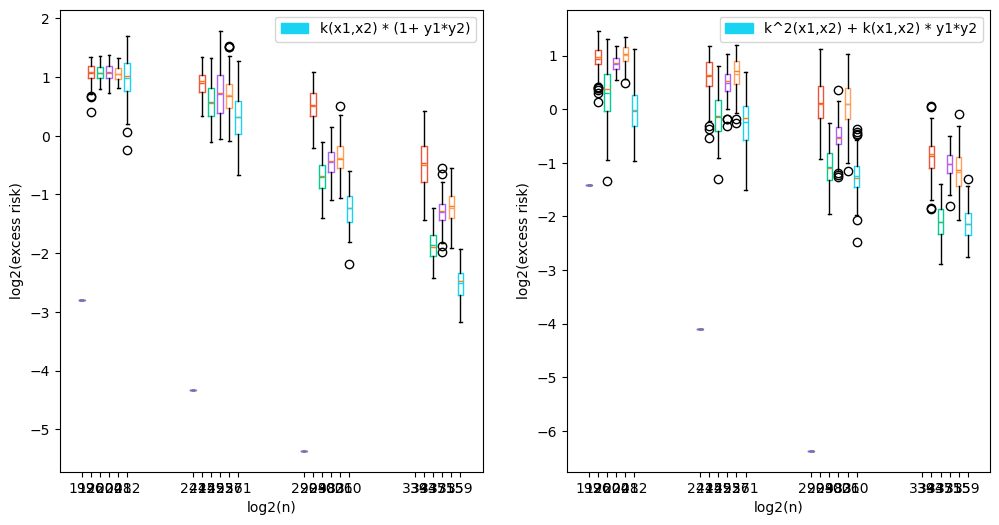

In [31]:
# make a matplotlib version of the above figure
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

def plot_matplotlib(all_scores, all_names, ax):
    for i, result in enumerate(all_scores):
        name = result['name']
        color = colors_list[all_names.index(name)]
        excess_risk = np.array(result["scores"]) - baseline_loss

        if scale == 'log2':
            y = np.log2(excess_risk)

        elif scale == 'linear':
            y = excess_risk

        ax.boxplot(
            y, 
            positions=[result['logn'] * len(all_scores) + i], 
            showmeans=True, 
            meanline=True, 
            meanprops=dict(color=color), 
            boxprops=dict(color=color),
            widths=2.5,
        )
        ax.set_xlabel("log2(n)")
        ax.set_ylabel(f"{scale}(excess risk)")

        ax.legend(handles=[Patch(color=color, label=name)])

plot_matplotlib(all_nw_scores, all_nw_names, ax[0])
plot_matplotlib(all_krr_scores, all_krr_names, ax[1])
plt.show()

In [ ]:

# fig_file = os.path.join(
#     fig_dir,
#     f"all-k={kernel}-gt={ground_truth}-logn={logn_lo}_{logn_hi}-t{n_trials}-excess-2-matplotlib.png"
# )
# fig.savefig(fig_file)

In [47]:
# sample synthetic data
from npr.util_sample import ToyData
X_name = 'unif'
toy_data_noise = ToyData(
    X_name=X_name, 
    f_name=ground_truth,
    noise=1.,
    d=d, 
    # k=1, #number of anchor points
    # k=8,
    # scale=8,
)

seed = 123
# X_train, y_train = toy_data_noise.sample(n)
X_test, y_test = toy_data_noise.sample(10000, seed=seed, shuffle=False)
print(X_test.shape, y_test.shape)
# validation set used for cross validation
# set different seed so that val and test data and different
X_val, y_val = toy_data_noise.sample(10000, seed=seed*2, shuffle=True)
print(X_val.shape, y_val.shape)

(10000, 1) (10000,)
(10000, 1) (10000,)


In [48]:
fig = px.scatter(x=X_val[:,0], y=y_val,
                # title=f'X={X_name}, f={ground_truth}, std[f]={np.std(y_val):.4f}',
                opacity=0.5,
                )
fig.update_layout(
    # title=f'X={X_name}, f={ground_truth}, std[f]={np.std(y_val):.4f}',
    # xaxis_title="X",
    # yaxis_title="y",
    width=800,
    height=600,
)

In [50]:
# save fig to file
fig_file = os.path.join(
    fig_dir,
    f"X={X_name}-f={ground_truth}-n=10000.png"
)
fig.write_image(fig_file)